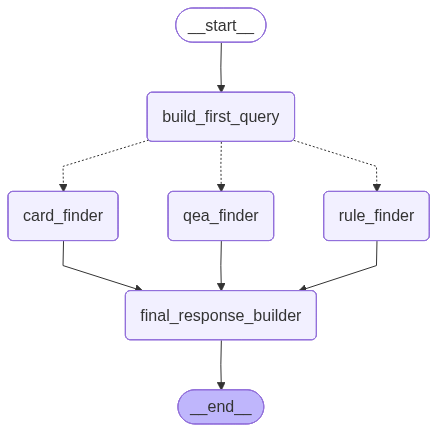

In [11]:
from langchain.agents import create_agent
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from pydantic import BaseModel

from langgraph.graph import START, END, StateGraph
from langgraph.types import Send

from schemas import *
from prompt_template import *

from dotenv import load_dotenv

from tools.chroma_search import get_from_chroma_card

load_dotenv()

# llm_model = 'gpt-5-nano-2025-08-07'
llm_model = 'gpt-4o-mini-2024-07-18'
llm = ChatOpenAI(model=llm_model)


#Nós
def build_first_query(state: ReportState):

    users_input = state.user_input
    prompt = build_queries.format(user_input=users_input)
    query_llm = llm.with_structured_output(QueryStructure)
    response = query_llm.invoke(prompt)
    return {"queries": response.inputs}

def translate_input(state: ReportState):

    users_input = state.user_input
    prompt = translate_template.format(input_msg=users_input)
    chain_translate = llm | StrOutputParser()
    result = chain_translate.invoke(prompt)
    print(result)
    return result

def card_finder(query: str):
    # tools = [card_search, get_from_chroma_card]
    tools = generic_sql_tool(llm).get_tools()
    system_prompt = card_finder_system_template
    user_prompt = {"messages": [{"role": "user", "content": query}]}

    result = send_to_llm_with_tools(user_prompt, tools, system_prompt)
    query_results = QueryResult(type="card_info", content=result["messages"][-1].content)
    return {"query_results": [query_results]}

def rule_finder(query: str):
    tools = generic_sql_tool(llm).get_tools()
    system_prompt = card_finder_system_template
    user_prompt = {"messages": [{"role": "user", "content": query}]}

    result = send_to_llm_with_tools(user_prompt, tools, system_prompt)
    query_results = QueryResult(type="rule_info", content=result["messages"][-1].content)
    return {"query_results": [query_results]}

def spawn_researchers(state:ReportState):
    query_list = state.queries
    send_list=[]
    for query in query_list:
        if(query.type == "CARD SEARCH"):
            send_list.append(Send("card_finder", prompt) for prompt in query.queries)
        elif (query.type == "RULE SEARCH"):
            send_list.append(Send("rule_finder", prompt) for prompt in query.queries)
        # elif (query.type == "Q&A SEARCH"):
        #     send_list.append(Send("qea_finder", prompt) for prompt in query.queries)
    return send_list

def send_to_llm_with_tools(query, tools, system_prompt):
    agent = create_agent(
        model=llm_model,
        tools=tools,
        system_prompt=system_prompt
    )
    result = agent.invoke(query)
    return result

def qea_finder(query: str):
    pass

def final_response_builder(state: ReportState):
    pass

#Edges

builder = StateGraph(ReportState)

builder.add_node("build_first_query", build_first_query)
# builder.add_node("translate_input", translate_input)
builder.add_node("card_finder", card_finder)
builder.add_node("rule_finder", rule_finder)
builder.add_node("qea_finder", qea_finder)
builder.add_node("final_response_builder", final_response_builder)

builder.add_edge(START, "build_first_query")
builder.add_conditional_edges("build_first_query", spawn_researchers, ["card_finder", "rule_finder", "qea_finder"])
builder.add_edge("card_finder", "final_response_builder")
builder.add_edge("rule_finder", "final_response_builder")
builder.add_edge("qea_finder", "final_response_builder")
builder.add_edge("final_response_builder", END)

graph = builder.compile()

if __name__ == "__main__":
    from IPython.display import Image, display
    image = Image(graph.get_graph().draw_mermaid_png())
    display(image)
    user_input = """
    Witch card has the effect "when attacking, draw 2 cards and trash 1", costs 4 and has the name cavendish?
    """
    # graph.invoke({"user_input": user_input})
    # data = {"user_input": user_input, "queries_results": []}
    # rs = ReportState(**data)
    # print(build_first_query(rs))
    # print(card_finder(user_input))

In [6]:
from langchain.tools import tool
import sqlite3
from pydantic import BaseModel, Field
from sympy.parsing.sympy_parser import null
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase

DATABASE_PATH = 'OPTCG_CardList.db'

class CardSearchArgs(BaseModel):
    search_params: str = Field(description='search_params is a string of a dictionary to be use as where clause on the select statement')

class RuleSearchArgs(BaseModel):
    rule_id: str = Field(description='rule_id represents the rule id that will be used on a select statement to retrieve the rule text. Examples: 1.2.2 or 3.6.4.1')


# def old_card_search(query:str = "SELECT * FROM op_tcg_card_list WHERE ID = 'ST14-003'"):
#     """Search for a card using a SQL as input and executing on a database that has the table named op_tcg_card_list.
#     SQL command must be valid
#     When using color search concat both colors with the first latter of each color in caps (Pascal Case) (exemple: BlackPurple, BlueBlack)
#     When using color search always try to switch color orders exemple: BlueRed, RedBlue
#     All columns except url, id, set and Card Type use Pascal Case patten
#     url, id, set and Card Type columns use all letters in caps
#     Exemples:
#         SELECT * FROM op_tcg_card_list WHERE ID = 'ST14-003'
#         SELECT * FROM op_tcg_card_list WHERE Title LIKE '%Luffy%' AND Set = 'OP09'"
#         SELECT * from op_tcg_card_list WHERE color LIKE '%Yellow%' AND Cost = 3 AND Title = 'Nami'
#         SELECT * from op_tcg_card_list WHERE color LIKE '%BlackYellow%' AND card_type = 'LEADER' AND Title = 'Monkey.D.Luffy'
#     Cards with the same id are just alternative arts of that card and can be ignored
#     The op_tcg_card_list columns are: URL,Effect,ID,Title,Price,Cost,Color,Types,Attributes,Rarity,Card Type,Power,Source,Set. Don't use ' or \" on column names. ID must be all in caps"""
#
#     # conn = psycopg2.connect(
#     #     database="postgres",
#     #     user='postgres',
#     #     password='123qwe',
#     #     host='localhost',
#     #     port='5432'
#     # )
#     conn = sqlite3.connect('../OPTCG_CardList.db')
#
#     cursor = conn.cursor()
#     query = query.replace("\"", "\'")
#     statements = sqlparse.parse(query)
#     for statement in statements:
#         print(statement)
#         if statement.get_type() == "SELECT":
#             cursor.execute(query)
#             response = cursor.fetchall()
#             return response
#         else:
#             return "query must be a well formed SELECT"

#receive dictionary as input and run a select with where clause
@tool(args_schema= CardSearchArgs)
def card_search(search_params: str):
    """ The input must be a string of a Dictionary with the variable search_params that must be a string formated as a dictionary to search on a database that has a table named card containing information about cards.
    that dictionary is used to create a where clause for the select statement
    All keys in the dictionary must be valid column names of the card table
    When using color search concat both colors with the first latter of each color in caps separated by a / (exemple: Black/Purple, Blue/Black)
    When using color search always try to switch color orders exemple: Blue/Red, Red/Blue
    All columns use Pascal Case patten
    Examples of values for the search_params:
        '{"search_params":"{"id": "ST14-003"}"}' // exact match
        '{"search_params":"{"name": "%Luffy%", "set": "OP09"}"}' // name contains Luffy and set is OP09
        '{"search_params":"{"color": "Yellow", "cost": 3, "name": "Nami"}"}' // color contains Yellow, cost is 3 and name is Nami
        '{"search_params":"{"color": "Black/Yellow", "card_type": "Leader", "name": "Monkey.D.Luffy"}"}' // color contains Black and Yellow, card type is Leader and name is Monkey.D.Luffy
    Cards with the same id are just alternative arts of that card and can be ignored
    The card columns are: id, name, card_type, color, cost, life, effect, "type", counter, power, "attribute", block, collection_name, collection_id, "trigger", trigger_effect. Don't use ' or \" on column names. ID must be all in caps
    the collection_id can be referred as set"""

    # conn = psycopg2.connect(
    #     database="postgres",
    #     user='postgres',
    #     password='123qwe',
    #     host='localhost',
    #     port='5432'
    # )
    conn = sqlite3.connect(DATABASE_PATH)

    cursor = conn.cursor()

    base_query = "SELECT * FROM card"

    #trosnform string representation of dictionary to actual dictionary
    print(f"Entrada tool = {search_params}")
    search_params = eval(search_params)

    for key, value in search_params.items():
        if key in ["name"]:
            search_params[key] = f"%{value}%"

    if not search_params:
        return "No search parameters provided"

    where_clauses = []
    values = []

    for key, value in search_params.items():
        print("Key:", key, "Value:", value)
        if isinstance(value, str) and '%' in value:
            where_clauses.append(f"{key} LIKE ?")
            values.append(value)
        else:
            where_clauses.append(f"{key} = ?")
            values.append(value)

    where_statement = " AND ".join(where_clauses)
    final_query = f"{base_query} WHERE {where_statement}"

    print(final_query)
    print(DATABASE_PATH)

    cursor.execute(final_query, values)
    return cursor.fetchall()

# return a list of existing tables
def list_tables():
    conn = sqlite3.connect(DATABASE_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    return [table[0] for table in tables]

# seach especific columns in the card table
def search_column(column_name: str, search_value: str):

    conn = sqlite3.connect(DATABASE_PATH)

    cursor = conn.cursor()

    base_query = f"SELECT * FROM card WHERE {column_name} = ?"

    cursor.execute(base_query, (search_value,))
    response = cursor.fetchall()
    return response

#receive dictionary as input and run a select with where clause
@tool(args_schema= RuleSearchArgs)
def rules_search(rule_id: str):
    """ Search for a rule using the rule_id on a database that has a table named rules containing information about game rules.
    Can be used to search for the text of a specific rule or to search for the context of a rule using the id of a more general rule. For example, rule 2.1.3 can be used to search for the text of rule 2.1.3 but also rule 2.1 can be used to search for the context of rule 2.1.3 since it is a more general rule that contains rule 2.1.3 as a subsection.
    The rules table columns are: id, rule
    the rule ids are in the format of numbers separated by dots, where each number represents a section or subsection of the rules. For example, rule 2.1.3 is a subsection of rule 2.1, which is a subsection of rule 2. This structure allows for a hierarchical organization of the rules, where more specific rules are nested under more general ones.
    Exemple of rule_id: '2.1.3' to search for the texto for rule 2.1.3
    Usefull to search for the context of rules.
    Exemple rule 3.1 give the context for rule 3.1.2"""

    conn = sqlite3.connect(DATABASE_PATH)

    cursor = conn.cursor()

    base_query = "SELECT id, rule FROM rules WHERE id = ?"

    rule_text = cursor.execute(base_query, (rule_id,)).fetchone()
    return rule_text

def generic_sql_tool(llm):
    db = SQLDatabase.from_uri(f"sqlite:///{DATABASE_PATH}")
    toolkit = SQLDatabaseToolkit(db=db, llm=llm)
    return toolkit